In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os, sys
os.chdir("..")
from Source.Models.autoregGMM import AutoRegGMM
import Source.Util.preprocessing as prep
from Source.Util.util import load_params, get, get_device
import torch
from torch.utils.data import DataLoader
from Source.Util.simulateToyData import ToySimulator
import torch.distributions as D

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
runpath = "runs/set15_gauss20_1/"

# Load data

In [3]:
modelpath = runpath + "models/model_run0.pt"
parampath = runpath + "paramfile.yaml"
params = load_params(parampath)
params["device"]=get_device()

In [4]:
data = ToySimulator(params).data
n_gauss = params["n_gauss"]

# Initialize modified model class

In [5]:
model = AutoRegGMM(params)
state_dict = torch.load(modelpath, map_location=params["device"])
model.load_state_dict(state_dict)

Model AutoRegGMM hyperparameters: n_head=4, n_per_head=15, n_blocks=4, intermediate_fac=4, n_gauss=20
Bayesianization hyperparameters: bayesian=0, prior_prec=1.0, iterations=1


<All keys matched successfully>

In [6]:
data_split = params["data_split"]
n_data = len(data)
cut1 = int(n_data - data_split[0])
model.train_loader = DataLoader(dataset=data[:cut1], batch_size=params["batch_size"], shuffle=True)

# Generate samples

In [7]:
n_samples = 10
samples, xs, probs, probsindiv = model.sample_n_bonus(n_samples, xmin=-.1, xmax=1.1)
samples = samples[:,1:]

print(samples)
print(np.shape(probs), np.shape(xs), np.shape(probsindiv), np.shape(samples), np.shape(data))

/usr/local/lib/python3.10/dist-packages/torch/distributions/distribution.py:167: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


[[0.97575647 0.9272942 ]
 [0.5911015  0.9373228 ]
 [0.37715918 0.92046905]
 [0.64438975 0.89705   ]
 [0.81044286 0.69472957]
 [0.2917113  0.9477612 ]
 [0.03287065 0.2539898 ]
 [0.9884497  0.98172086]
 [0.6831975  0.8181238 ]
 [0.00410213 0.1529142 ]]
(10, 2, 1000) (2, 1000) (10, 2, 20, 1000) (10, 2) (1000000, 2)


# Test plot

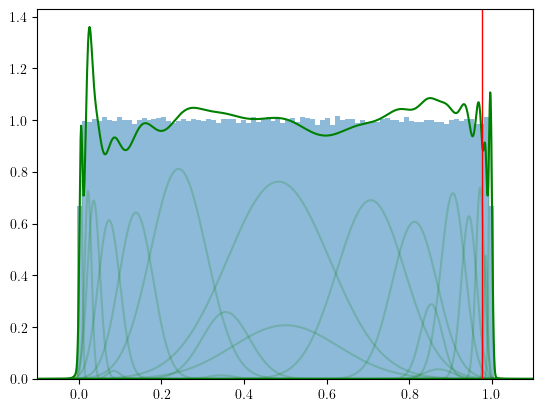

In [8]:
idim=0
isample=0
bins=100
xmin=np.min(xs[idim,:])
xmax=np.max(xs[idim,:])
plt.hist(data[:,idim], alpha=.5, bins=bins, range=(xmin, xmax), density=True, align="mid", rwidth=1.)
plt.plot(xs[idim,:], probs[isample, idim, :], color="g")
for igauss in range(n_gauss):
    plt.plot(xs[idim,:], probsindiv[isample,idim,igauss,:], color="g", linestyle="-", alpha=.2)
_, ymax = plt.ylim()
plt.vlines(samples[isample,idim], 0., ymax, "r", linewidth=1)
plt.xlim(xmin, xmax)
plt.ylim(0., ymax)
plt.show()

# Marginalization

In [7]:
def getMargLikelihood(model, xmin, xmax, prec=1000):
    n_samples = 1
    _, xs, probs, _ = model.sample_n_bonus(n_samples, xmin, xmax, prec=prec)
    return xs[0,:], probs[0,0,:]

In [8]:
def getMargLikelihoodnDim(model, xmin, xmax, dim, prec=1000):
    xs = torch.linspace(xmin, xmax, prec)
    idx = model.n_jets * torch.ones(prec, 2, dtype=torch.int).float()
    idx[:,1] = xs
    
    mu, sigma, weights = model.net(idx) #indices: batch, component, gauss
    mix = D.Categorical(weights)
    comp = D.Normal(mu, sigma)
    gmm = D.MixtureSameFamily(mix, comp)
    
    probs = torch.zeros(prec, prec, dtype=torch.float) #likelihood array
    for ix in range(prec):
        base = torch.zeros(prec, 2)
        base[:,0] = xs[ix]
        base[:,1] = xs
        probs[ix,:] = torch.exp(torch.sum(gmm.log_prob(base), axis=-1))
    probs = probs.detach().cpu().numpy()
    xs = xs.detach().cpu().numpy()
    
    marg = np.trapz(probs, x=xs, axis=dim)
    #norm = np.trapz(marg, x=xs)
    #print(f"Normalization: {norm:.5f}")
    
    return xs, marg

In [10]:
prec = 1000
xmin = -.1
xmax = 1.1
nruns = 30
nrunsEnsemble = 9
ngauss = [5,10,20,30,50,100]

# Ensembles

In [12]:
xs = np.zeros(prec)
margL = np.zeros((prec, len(ngauss), nruns))
for i in range(len(ngauss)):
    igauss = ngauss[i]
    for j in range(nrunsEnsemble):
        runpath = f"runs/set15_gauss{igauss}_{1+j}/"
        modelpath = runpath + "models/model_run0.pt"
        parampath = runpath + "paramfile.yaml"
        params = load_params(parampath)
        params["device"]=get_device()
        model = AutoRegGMM(params)
        state_dict = torch.load(modelpath, map_location=params["device"])
        model.load_state_dict(state_dict)
        model.train_loader = DataLoader(dataset=data[:cut1], batch_size=params["batch_size"], shuffle=True)
        xs, margL[:,i,j] = getMargLikelihood(model, xmin, xmax, prec=prec)

Model AutoRegGMM hyperparameters: n_head=4, n_per_head=15, n_blocks=4, intermediate_fac=4, n_gauss=5
Bayesianization hyperparameters: bayesian=0, prior_prec=1.0, iterations=1


/usr/local/lib/python3.10/dist-packages/torch/distributions/distribution.py:167: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


Model AutoRegGMM hyperparameters: n_head=4, n_per_head=15, n_blocks=4, intermediate_fac=4, n_gauss=5
Bayesianization hyperparameters: bayesian=0, prior_prec=1.0, iterations=1
Model AutoRegGMM hyperparameters: n_head=4, n_per_head=15, n_blocks=4, intermediate_fac=4, n_gauss=5
Bayesianization hyperparameters: bayesian=0, prior_prec=1.0, iterations=1
Model AutoRegGMM hyperparameters: n_head=4, n_per_head=15, n_blocks=4, intermediate_fac=4, n_gauss=5
Bayesianization hyperparameters: bayesian=0, prior_prec=1.0, iterations=1
Model AutoRegGMM hyperparameters: n_head=4, n_per_head=15, n_blocks=4, intermediate_fac=4, n_gauss=5
Bayesianization hyperparameters: bayesian=0, prior_prec=1.0, iterations=1
Model AutoRegGMM hyperparameters: n_head=4, n_per_head=15, n_blocks=4, intermediate_fac=4, n_gauss=5
Bayesianization hyperparameters: bayesian=0, prior_prec=1.0, iterations=1
Model AutoRegGMM hyperparameters: n_head=4, n_per_head=15, n_blocks=4, intermediate_fac=4, n_gauss=5
Bayesianization hyperpar

Model AutoRegGMM hyperparameters: n_head=4, n_per_head=15, n_blocks=4, intermediate_fac=4, n_gauss=100
Bayesianization hyperparameters: bayesian=0, prior_prec=1.0, iterations=1
Model AutoRegGMM hyperparameters: n_head=4, n_per_head=15, n_blocks=4, intermediate_fac=4, n_gauss=100
Bayesianization hyperparameters: bayesian=0, prior_prec=1.0, iterations=1


KeyboardInterrupt: 

In [ ]:
meanMargL = np.zeros((prec, len(ngauss)))
stdMargL = np.zeros((prec, len(ngauss)))
for i in range(len(ngauss)):
    meanMargL[:,i] = np.mean(margL[:,i,:], axis=1)
    stdMargL[:,i] = np.std(margL[:,i,:], axis=1)

In [ ]:
bins=100
xmin = -.1
xmax = 1.1
ymin = 0.
ymax = 1.3

fig=plt.figure(figsize=(16,8))

col = mpl.cm.Set1(np.linspace(0,1,9))
for i in range(len(ngauss)):
    
    fig.add_subplot(2,3,i+1)
    plt.hist(data[:,0], alpha=.5, bins=bins, range=(xmin, xmax), density=True, color=col[1], align="mid", rwidth=1.)

    igauss = ngauss[i]
    for j in range(nruns):
        plt.plot(xs, margL[:,i,j], color=col[2], alpha=.3)
    plt.plot(xs, meanMargL[:,i], color=col[0], alpha=1., label=f"n_gauss={igauss}")
    plt.fill_between(xs, meanMargL[:,i]+stdMargL[:,i], meanMargL[:,i]-stdMargL[:,i], color=col[0], alpha=.3)
    

    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.xlabel(r"$x$")
    plt.legend()
plt.savefig("Scripts/margUnc/ensemble_flat.pdf", bbox_inches="tight")
plt.show()

In [ ]:
ymin = 0.
ymax = .2
fig=plt.figure(figsize=(8,4))
fig.add_subplot(1,1,1)
for i in range(len(ngauss)):
    igauss = ngauss[i]
    plt.plot(xs, stdMargL[:,i], color=col[i], label=f"n_gauss={igauss}")
    
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.xlabel(r"$x$")
    plt.ylabel(r"$\sigma$")
    plt.legend()
plt.savefig("Scripts/margUnc/ensemble_flat_unc.pdf", bbox_inches="tight")
plt.show()

In [ ]:
xs = np.zeros(prec)
margL = np.zeros((prec, len(ngauss), nruns))
for i in range(len(ngauss)):
    igauss = ngauss[i]
    for j in range(nrunsEnsemble):
        runpath = f"runs/set15_gauss{igauss}_{1+j}/"
        modelpath = runpath + "models/model_run0.pt"
        parampath = runpath + "paramfile.yaml"
        params = load_params(parampath)
        params["device"]=get_device()
        model = AutoRegGMM(params)
        state_dict = torch.load(modelpath, map_location=params["device"])
        model.load_state_dict(state_dict)
        model.train_loader = DataLoader(dataset=data[:cut1], batch_size=params["batch_size"], shuffle=True)
        xs, margL[:,i,j] = getMargLikelihoodnDim(model, xmin, xmax, 1, prec=prec)

In [ ]:
meanMargL = np.zeros((prec, len(ngauss)))
stdMargL = np.zeros((prec, len(ngauss)))
for i in range(len(ngauss)):
    meanMargL[:,i] = np.mean(margL[:,i,:], axis=1)
    stdMargL[:,i] = np.std(margL[:,i,:], axis=1)

In [ ]:
bins=100
xmin = -.1
xmax = 1.1
ymin = 0.
ymax = 1.3

fig=plt.figure(figsize=(16,8))

col = mpl.cm.Set1(np.linspace(0,1,9))
for i in range(len(ngauss)):
    
    fig.add_subplot(2,3,i+1)
    plt.hist(data[:,0], alpha=.5, bins=bins, range=(xmin, xmax), density=True, color=col[1], align="mid", rwidth=1.)

    igauss = ngauss[i]
    for j in range(nruns):
        plt.plot(xs, margL[:,i,j], color=col[2], alpha=.3)
    plt.plot(xs, meanMargL[:,i], color=col[0], alpha=1., label=f"n_gauss={igauss}")
    plt.fill_between(xs, meanMargL[:,i]+stdMargL[:,i], meanMargL[:,i]-stdMargL[:,i], color=col[0], alpha=.3)
    

    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.xlabel(r"$x$")
    plt.legend()
plt.savefig("Scripts/margUnc/ensemble_flat2.pdf", bbox_inches="tight")
plt.show()

In [ ]:
ymin = 0.
ymax = .2
fig=plt.figure(figsize=(8,4))
fig.add_subplot(1,1,1)
for i in range(len(ngauss)):
    igauss = ngauss[i]
    plt.plot(xs, stdMargL[:,i], color=col[i], label=f"n_gauss={igauss}")
    
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.xlabel(r"$x$")
    plt.ylabel(r"$\sigma$")
    plt.legend()
plt.savefig("Scripts/margUnc/ensemble_flat2_unc.pdf", bbox_inches="tight")
plt.show()

# Uncertainties from ensembles (second dimension)

In [ ]:
def getMargLikelihood2ndDim(runpath, xmin, xmax, prec=1000):
    modelpath = runpath + "models/model_run0.pt"
    parampath = runpath + "paramfile.yaml"
    params = load_params(parampath)
    params["device"]=get_device()
    
    model = AutoRegGMM(params)
    state_dict = torch.load(modelpath, map_location=params["device"])
    model.load_state_dict(state_dict)
    model.train_loader = DataLoader(dataset=data[:cut1], batch_size=params["batch_size"], shuffle=True)
    
    xs = torch.linspace(xmin, xmax, prec)
    idx = 2 * torch.ones(prec, 2, dtype=torch.int).float()
    idx[:,1] = xs
    
    mu, sigma, weights = model.net(idx)                
    mix = D.Categorical(weights[:,-1,:])
    comp = D.Normal(mu[:,-1,:], sigma[:,-1,:])
    gmm = D.MixtureSameFamily(mix, comp)
    
    probs = torch.zeros(prec, prec, dtype=torch.float) #likelihood array
    for ix in range(prec):
        probs[ix,:] = torch.exp(gmm.log_prob(xs[ix]))
    probs = probs.detach().cpu().numpy()
    
    marg = np.trapz(probs, x=xs, axis=1) /1.2
    norm = np.trapz(marg, x=xs)
    print(f"Normalization: {norm:.5f}")
    
    return xs, marg

In [ ]:
xs = np.zeros(prec)
margL = np.zeros((prec, len(ngauss), nruns))
for i in range(len(ngauss)):
    igauss = ngauss[i]
    for j in range(nrunsEnsemble):
        runpath = f"runs/set15_gauss{igauss}_{1+j}/"
        modelpath = runpath + "models/model_run0.pt"
        parampath = runpath + "paramfile.yaml"
        params = load_params(parampath)
        params["device"]=get_device()
        model = AutoRegGMM(params)
        state_dict = torch.load(modelpath, map_location=params["device"])
        model.load_state_dict(state_dict)
        model.train_loader = DataLoader(dataset=data[:cut1], batch_size=params["batch_size"], shuffle=True)
        xs, margL[:,i,j] = getMargLikelihoodnDim(model, xmin, xmax, 0, prec=prec)

In [ ]:
meanMargL = np.zeros((prec, len(ngauss)))
stdMargL = np.zeros((prec, len(ngauss)))
for i in range(len(ngauss)):
    meanMargL[:,i] = np.mean(margL[:,i,:], axis=1)
    stdMargL[:,i] = np.std(margL[:,i,:], axis=1)

In [ ]:
bins=100
xmin = -.1
xmax = 1.1
ymin = 0.
ymax = 3.

fig=plt.figure(figsize=(16,8))

col = mpl.cm.Set1(np.linspace(0,1,9))
for i in range(len(ngauss)):
    
    fig.add_subplot(2,3,i+1)
    plt.hist(data[:,1], alpha=.5, bins=bins, range=(xmin, xmax), density=True, color=col[1], align="mid", rwidth=1.)

    igauss = ngauss[i]
    for j in range(nruns):
        plt.plot(xs, margL[:,i,j], color=col[2], alpha=.3)
    plt.plot(xs, meanMargL[:,i], color=col[0], alpha=1., label=f"n_gauss={igauss}")
    plt.fill_between(xs, meanMargL[:,i]+stdMargL[:,i], meanMargL[:,i]-stdMargL[:,i], color=col[0], alpha=.3)
    

    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.xlabel(r"$y$")
    plt.legend()
plt.savefig("Scripts/margUnc/ensemble_lin.pdf", bbox_inches="tight")
plt.show()

In [ ]:
ymin = 0.
ymax = .2
fig=plt.figure(figsize=(8,4))
fig.add_subplot(1,1,1)
for i in range(len(ngauss)):
    igauss = ngauss[i]
    plt.plot(xs, stdMargL[:,i], color=col[i], label=f"n_gauss={igauss}")
    
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.xlabel(r"$y$")
    plt.ylabel(r"$\sigma$")
    plt.legend()
plt.savefig("Scripts/margUnc/ensemble_lin_unc.pdf", bbox_inches="tight")
plt.show()

# Uncertainties from BALPs (only first dimension)

In [11]:
xs = np.zeros(prec)
margL = np.zeros((prec, len(ngauss), nruns))
for k in range(len(ngauss)):
    igauss = ngauss[k]
    runpath = f"runs/set15_gauss{igauss}_BALP/"
    if igauss==50:
        runpath = "runs/set15_gauss50_BALP_2/"
    modelpath = runpath + "models/model_run0.pt"
    #modelpath = runpath + "models/model_epoch_1000.pt"
    parampath = runpath + "paramfile.yaml"
    params = load_params(parampath)
    params["device"]=get_device()
    model = AutoRegGMM(params)
    state_dict = torch.load(modelpath, map_location=params["device"])
    model.load_state_dict(state_dict)
    model.train_loader = DataLoader(dataset=data[:cut1], batch_size=params["batch_size"], shuffle=True)
    for j in range(nruns):
        if model.net.bayesian >= 1:
            model.net.map = get(model.params, "fix_mu", False)
            for i in range(model.net.n_blocks):
                model.net.transformer.h[i].mlp.c_fc.random = None
                model.net.transformer.h[i].mlp.c_proj.random = None
        if model.net.bayesian >= 2:
            for i in range(model.net.n_blocks):
                model.net.transformer.h[i].attn.c_attn.random = None
                model.net.transformer.h[i].attn.c_proj.random = None
        if model.net.bayesian >= 3:
            model.net.transformer.wte.random = None
            model.net.lm_head.random = None
        xs, margL[:,k,j] = getMargLikelihood(model, xmin, xmax, prec=prec)

Model AutoRegGMM hyperparameters: n_head=4, n_per_head=15, n_blocks=4, intermediate_fac=4, n_gauss=5
Bayesianization hyperparameters: bayesian=2, prior_prec=1.0, iterations=20


/usr/local/lib/python3.10/dist-packages/torch/distributions/distribution.py:167: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


Model AutoRegGMM hyperparameters: n_head=4, n_per_head=15, n_blocks=4, intermediate_fac=4, n_gauss=10
Bayesianization hyperparameters: bayesian=2, prior_prec=1.0, iterations=20
Model AutoRegGMM hyperparameters: n_head=4, n_per_head=15, n_blocks=4, intermediate_fac=4, n_gauss=20
Bayesianization hyperparameters: bayesian=2, prior_prec=1.0, iterations=20
Model AutoRegGMM hyperparameters: n_head=4, n_per_head=15, n_blocks=4, intermediate_fac=4, n_gauss=30
Bayesianization hyperparameters: bayesian=2, prior_prec=1.0, iterations=20
Model AutoRegGMM hyperparameters: n_head=4, n_per_head=15, n_blocks=4, intermediate_fac=4, n_gauss=50
Bayesianization hyperparameters: bayesian=2, prior_prec=1.0, iterations=20
Model AutoRegGMM hyperparameters: n_head=4, n_per_head=15, n_blocks=4, intermediate_fac=4, n_gauss=100
Bayesianization hyperparameters: bayesian=2, prior_prec=1.0, iterations=20


In [12]:
meanMargL = np.zeros((prec, len(ngauss)))
stdMargL = np.zeros((prec, len(ngauss)))
for i in range(len(ngauss)):
    meanMargL[:,i] = np.mean(margL[:,i,:], axis=1)
    stdMargL[:,i] = np.std(margL[:,i,:], axis=1)

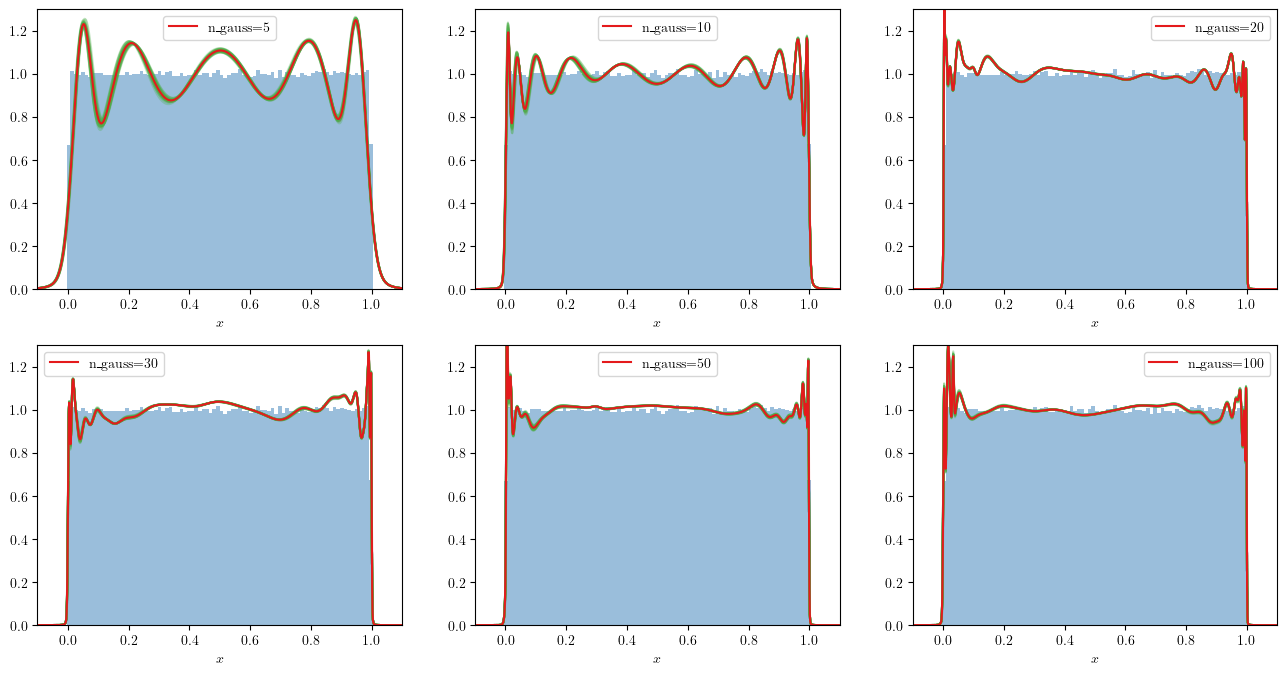

In [13]:
bins=100
xmin = -.1
xmax = 1.1
ymin = 0.
ymax = 1.3

fig=plt.figure(figsize=(16,8))

col = mpl.cm.Set1(np.linspace(0,1,9))
for i in range(len(ngauss)):
    
    fig.add_subplot(2,3,i+1)
    plt.hist(data[:,0], alpha=.5, bins=bins, range=(xmin, xmax), density=True, color=col[1], align="mid", rwidth=1.)

    igauss = ngauss[i]
    for j in range(nruns):
        plt.plot(xs, margL[:,i,j], color=col[2], alpha=.3)
    plt.plot(xs, meanMargL[:,i], color=col[0], alpha=1., label=f"n_gauss={igauss}")
    plt.fill_between(xs, meanMargL[:,i]+stdMargL[:,i], meanMargL[:,i]-stdMargL[:,i], color=col[0], alpha=.3)
    

    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.xlabel(r"$x$")
    plt.legend()
plt.savefig("Scripts/margUnc/balp2_flat.pdf", bbox_inches="tight")
plt.show()

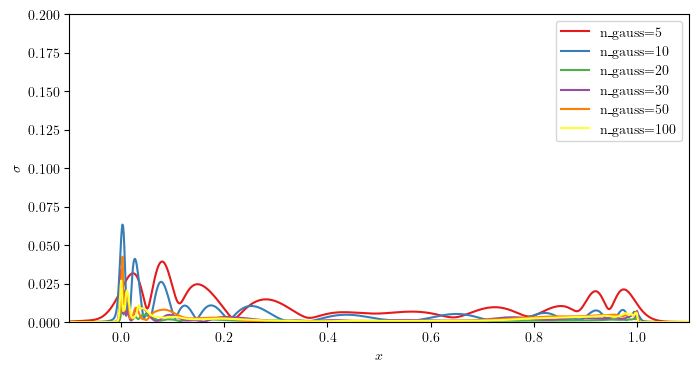

In [14]:
ymin = 0.
ymax = .2
fig=plt.figure(figsize=(8,4))
fig.add_subplot(1,1,1)
for i in range(len(ngauss)):
    igauss = ngauss[i]
    plt.plot(xs, stdMargL[:,i], color=col[i], label=f"n_gauss={igauss}")
    
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.xlabel(r"$x$")
    plt.ylabel(r"$\sigma$")
    plt.legend()
plt.savefig("Scripts/margUnc/balp2_flat_unc.pdf", bbox_inches="tight")
plt.show()

In [15]:
xs = np.zeros(prec)
margL = np.zeros((prec, len(ngauss), nruns))
for k in range(len(ngauss)):
    igauss = ngauss[k]
    runpath = f"runs/set15_gauss{igauss}_BALP/"
    if igauss==50:
        runpath = "runs/set15_gauss50_BALP_2/"
    modelpath = runpath + "models/model_run0.pt"
    #modelpath = runpath + "models/model_epoch_1000.pt"
    parampath = runpath + "paramfile.yaml"
    params = load_params(parampath)
    params["device"]=get_device()
    model = AutoRegGMM(params)
    state_dict = torch.load(modelpath, map_location=params["device"])
    model.load_state_dict(state_dict)
    model.train_loader = DataLoader(dataset=data[:cut1], batch_size=params["batch_size"], shuffle=True)
    for j in range(nruns):
        if model.net.bayesian >= 1:
            model.net.map = get(model.params, "fix_mu", False)
            for i in range(model.net.n_blocks):
                model.net.transformer.h[i].mlp.c_fc.random = None
                model.net.transformer.h[i].mlp.c_proj.random = None
        if model.net.bayesian >= 2:
            for i in range(model.net.n_blocks):
                model.net.transformer.h[i].attn.c_attn.random = None
                model.net.transformer.h[i].attn.c_proj.random = None
        if model.net.bayesian >= 3:
            model.net.transformer.wte.random = None
            model.net.lm_head.random = None
        xs, margL[:,k,j] = getMargLikelihoodnDim(model, xmin, xmax, 1, prec=prec)

Model AutoRegGMM hyperparameters: n_head=4, n_per_head=15, n_blocks=4, intermediate_fac=4, n_gauss=5
Bayesianization hyperparameters: bayesian=2, prior_prec=1.0, iterations=20
Model AutoRegGMM hyperparameters: n_head=4, n_per_head=15, n_blocks=4, intermediate_fac=4, n_gauss=10
Bayesianization hyperparameters: bayesian=2, prior_prec=1.0, iterations=20
Model AutoRegGMM hyperparameters: n_head=4, n_per_head=15, n_blocks=4, intermediate_fac=4, n_gauss=20
Bayesianization hyperparameters: bayesian=2, prior_prec=1.0, iterations=20
Model AutoRegGMM hyperparameters: n_head=4, n_per_head=15, n_blocks=4, intermediate_fac=4, n_gauss=30
Bayesianization hyperparameters: bayesian=2, prior_prec=1.0, iterations=20
Model AutoRegGMM hyperparameters: n_head=4, n_per_head=15, n_blocks=4, intermediate_fac=4, n_gauss=50
Bayesianization hyperparameters: bayesian=2, prior_prec=1.0, iterations=20
Model AutoRegGMM hyperparameters: n_head=4, n_per_head=15, n_blocks=4, intermediate_fac=4, n_gauss=100
Bayesianizati

In [16]:
meanMargL = np.zeros((prec, len(ngauss)))
stdMargL = np.zeros((prec, len(ngauss)))
for i in range(len(ngauss)):
    meanMargL[:,i] = np.mean(margL[:,i,:], axis=1)
    stdMargL[:,i] = np.std(margL[:,i,:], axis=1)

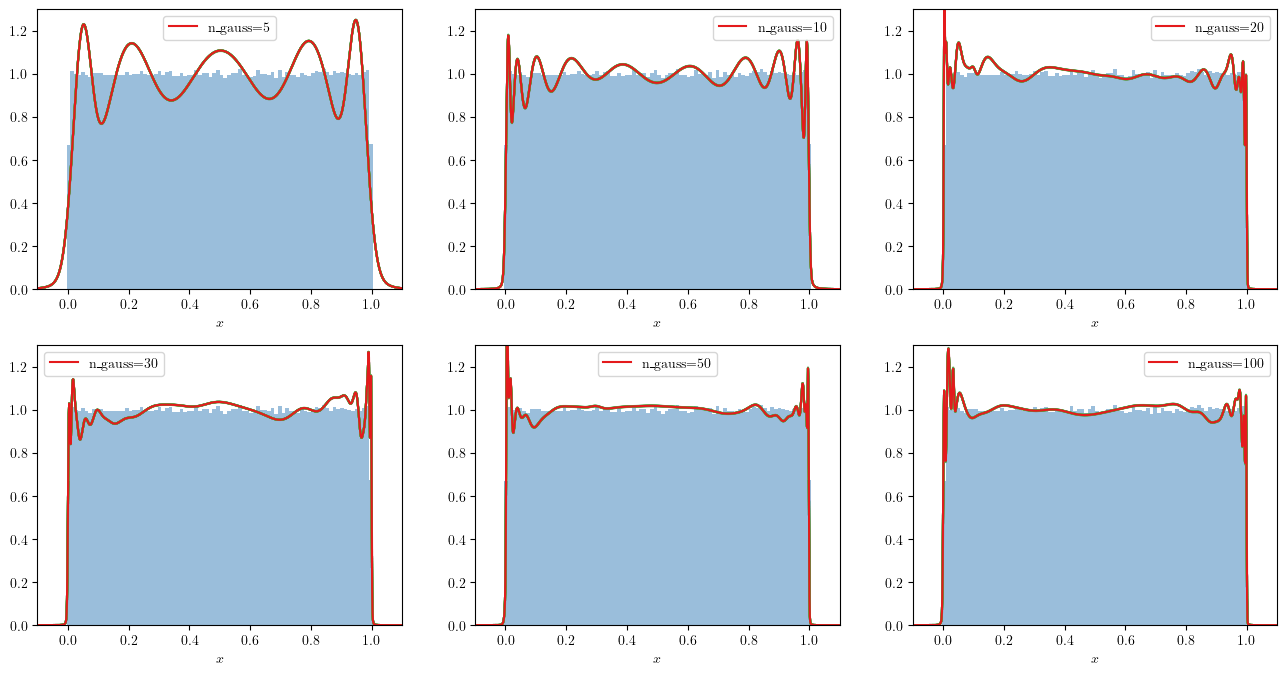

In [17]:
bins=100
xmin = -.1
xmax = 1.1
ymin = 0.
ymax = 1.3

fig=plt.figure(figsize=(16,8))

col = mpl.cm.Set1(np.linspace(0,1,9))
for i in range(len(ngauss)):
    
    fig.add_subplot(2,3,i+1)
    plt.hist(data[:,0], alpha=.5, bins=bins, range=(xmin, xmax), density=True, color=col[1], align="mid", rwidth=1.)

    igauss = ngauss[i]
    for j in range(nruns):
        plt.plot(xs, margL[:,i,j], color=col[2], alpha=.3)
    plt.plot(xs, meanMargL[:,i], color=col[0], alpha=1., label=f"n_gauss={igauss}")
    plt.fill_between(xs, meanMargL[:,i]+stdMargL[:,i], meanMargL[:,i]-stdMargL[:,i], color=col[0], alpha=.3)
    

    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.xlabel(r"$x$")
    plt.legend()
plt.savefig("Scripts/margUnc/balp2_flat2.pdf", bbox_inches="tight")
plt.show()

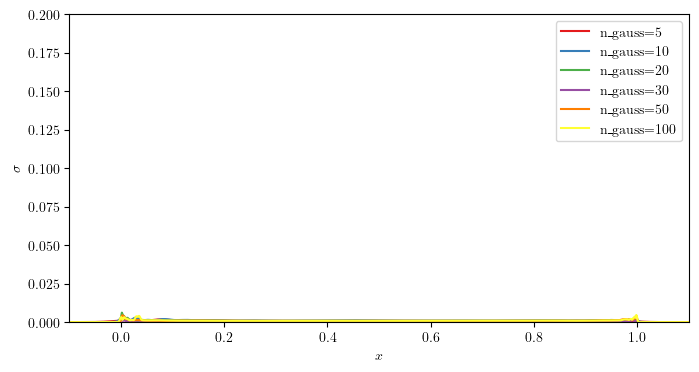

In [18]:
ymin = 0.
ymax = .2
fig=plt.figure(figsize=(8,4))
fig.add_subplot(1,1,1)
for i in range(len(ngauss)):
    igauss = ngauss[i]
    plt.plot(xs, stdMargL[:,i], color=col[i], label=f"n_gauss={igauss}")
    
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.xlabel(r"$x$")
    plt.ylabel(r"$\sigma$")
    plt.legend()
plt.savefig("Scripts/margUnc/balp2_flat2_unc.pdf", bbox_inches="tight")
plt.show()

 # Uncertainties from BALPs (second dimension)

In [19]:
xs = np.zeros(prec)
margL = np.zeros((prec, len(ngauss), nruns))
for k in range(len(ngauss)):
    igauss = ngauss[k]
    runpath = f"runs/set15_gauss{igauss}_BALP/"
    if igauss==50:
        runpath = f"runs/set15_gauss50_BALP_2/"
    modelpath = runpath + "models/model_run0.pt"
    #modelpath = runpath + "models/model_epoch_1.pt"
    parampath = runpath + "paramfile.yaml"
    params = load_params(parampath)
    params["device"]=get_device()
    model = AutoRegGMM(params)
    state_dict = torch.load(modelpath, map_location=params["device"])
    model.load_state_dict(state_dict)
    model.train_loader = DataLoader(dataset=data[:cut1], batch_size=params["batch_size"], shuffle=True)
    for j in range(nruns):
        if model.net.bayesian >= 1:
            model.net.map = get(model.params, "fix_mu", False)
            for i in range(model.net.n_blocks):
                model.net.transformer.h[i].mlp.c_fc.random = None
                model.net.transformer.h[i].mlp.c_proj.random = None
        if model.net.bayesian >= 2:
            for i in range(model.net.n_blocks):
                model.net.transformer.h[i].attn.c_attn.random = None
                model.net.transformer.h[i].attn.c_proj.random = None
        if model.net.bayesian >= 3:
            model.net.transformer.wte.random = None
            model.net.lm_head.random = None
        xs, margL[:,k,j] = getMargLikelihoodnDim(model, xmin, xmax, 0, prec=prec)

Model AutoRegGMM hyperparameters: n_head=4, n_per_head=15, n_blocks=4, intermediate_fac=4, n_gauss=5
Bayesianization hyperparameters: bayesian=2, prior_prec=1.0, iterations=20
Model AutoRegGMM hyperparameters: n_head=4, n_per_head=15, n_blocks=4, intermediate_fac=4, n_gauss=10
Bayesianization hyperparameters: bayesian=2, prior_prec=1.0, iterations=20
Model AutoRegGMM hyperparameters: n_head=4, n_per_head=15, n_blocks=4, intermediate_fac=4, n_gauss=20
Bayesianization hyperparameters: bayesian=2, prior_prec=1.0, iterations=20
Model AutoRegGMM hyperparameters: n_head=4, n_per_head=15, n_blocks=4, intermediate_fac=4, n_gauss=30
Bayesianization hyperparameters: bayesian=2, prior_prec=1.0, iterations=20
Model AutoRegGMM hyperparameters: n_head=4, n_per_head=15, n_blocks=4, intermediate_fac=4, n_gauss=50
Bayesianization hyperparameters: bayesian=2, prior_prec=1.0, iterations=20
Model AutoRegGMM hyperparameters: n_head=4, n_per_head=15, n_blocks=4, intermediate_fac=4, n_gauss=100
Bayesianizati

In [20]:
meanMargL = np.zeros((prec, len(ngauss)))
stdMargL = np.zeros((prec, len(ngauss)))
for i in range(len(ngauss)):
    meanMargL[:,i] = np.mean(margL[:,i,:], axis=1)
    stdMargL[:,i] = np.std(margL[:,i,:], axis=1)

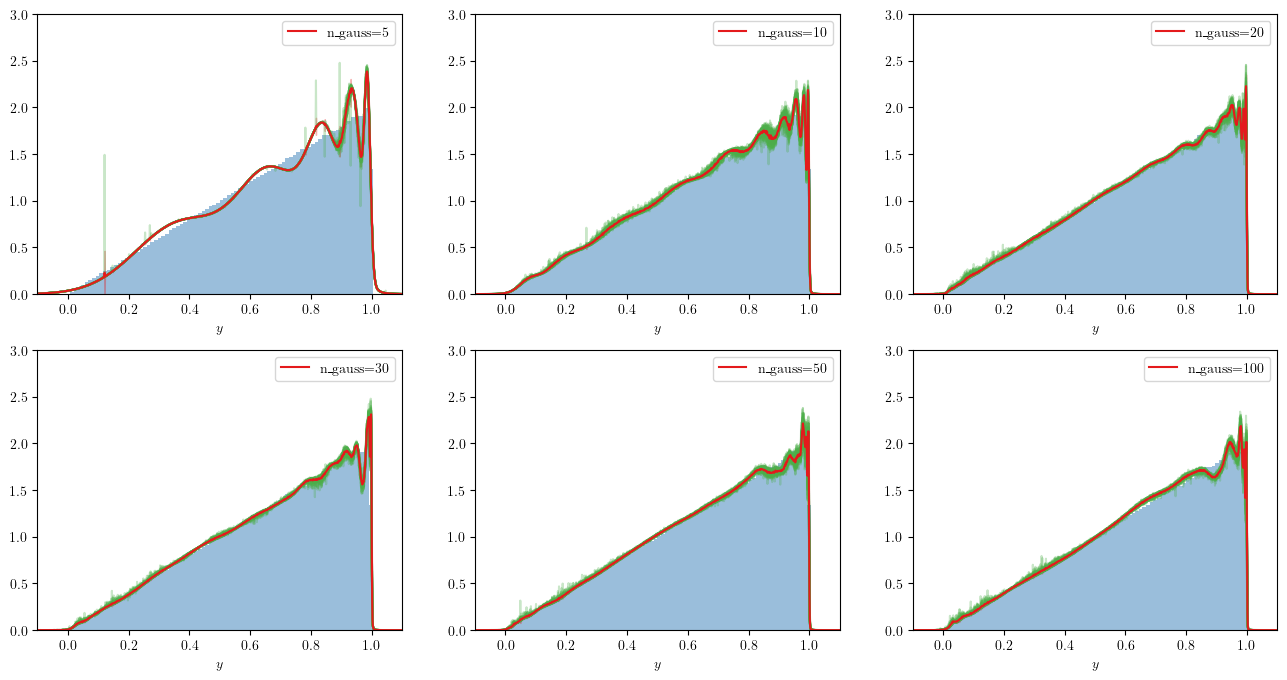

In [21]:
bins=100
xmin = -.1
xmax = 1.1
ymin = 0.
ymax = 3.

fig=plt.figure(figsize=(16,8))

col = mpl.cm.Set1(np.linspace(0,1,9))
for i in range(len(ngauss)):
    
    fig.add_subplot(2,3,i+1)
    plt.hist(data[:,1], alpha=.5, bins=bins, range=(xmin, xmax), density=True, color=col[1], align="mid", rwidth=1.)

    igauss = ngauss[i]
    for j in range(nruns):
        plt.plot(xs, margL[:,i,j], color=col[2], alpha=.3)
    plt.plot(xs, meanMargL[:,i], color=col[0], alpha=1., label=f"n_gauss={igauss}")
    plt.fill_between(xs, meanMargL[:,i]+stdMargL[:,i], meanMargL[:,i]-stdMargL[:,i], color=col[0], alpha=.3)
    

    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.xlabel(r"$y$")
    plt.legend()
plt.savefig("Scripts/margUnc/balp2_lin.pdf", bbox_inches="tight")
plt.show()

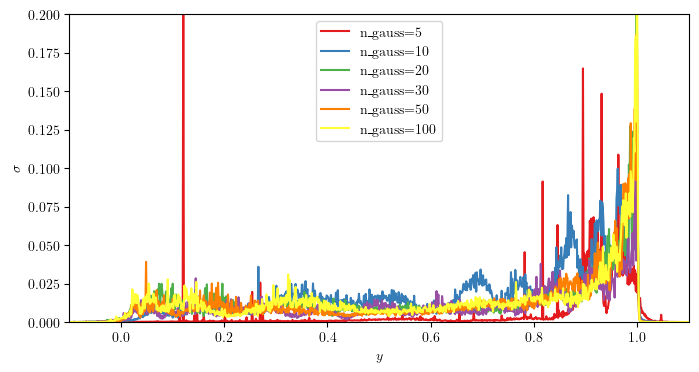

In [23]:
ymin = 0.
ymax = .2
fig=plt.figure(figsize=(8,4))
fig.add_subplot(1,1,1)
for i in range(len(ngauss)):
    igauss = ngauss[i]
    plt.plot(xs, stdMargL[:,i], color=col[i], label=f"n_gauss={igauss}")
    
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.xlabel(r"$y$")
    plt.ylabel(r"$\sigma$")
    plt.legend()
plt.savefig("Scripts/margUnc/balp2_lin_unc.pdf", bbox_inches="tight")
plt.show()

# Uncertainties from BALPs (only first dimension)

In [24]:
xs = np.zeros(prec)
margL = np.zeros((prec, len(ngauss), nruns))
for k in range(len(ngauss)):
    igauss = ngauss[k]
    runpath = f"runs/set15_gauss{igauss}_b3_BALP/"
    modelpath = runpath + "models/model_run0.pt"
    #modelpath = runpath + "models/model_epoch_1000.pt"
    parampath = runpath + "paramfile.yaml"
    params = load_params(parampath)
    params["device"]=get_device()
    model = AutoRegGMM(params)
    state_dict = torch.load(modelpath, map_location=params["device"])
    model.load_state_dict(state_dict)
    model.train_loader = DataLoader(dataset=data[:cut1], batch_size=params["batch_size"], shuffle=True)
    for j in range(nruns):
        if model.net.bayesian >= 1:
            model.net.map = get(model.params, "fix_mu", False)
            for i in range(model.net.n_blocks):
                model.net.transformer.h[i].mlp.c_fc.random = None
                model.net.transformer.h[i].mlp.c_proj.random = None
        if model.net.bayesian >= 2:
            for i in range(model.net.n_blocks):
                model.net.transformer.h[i].attn.c_attn.random = None
                model.net.transformer.h[i].attn.c_proj.random = None
        if model.net.bayesian >= 3:
            model.net.transformer.wte.random = None
            model.net.lm_head.random = None
        xs, margL[:,k,j] = getMargLikelihood(model, xmin, xmax, prec=prec)

Model AutoRegGMM hyperparameters: n_head=4, n_per_head=15, n_blocks=4, intermediate_fac=4, n_gauss=5
Bayesianization hyperparameters: bayesian=3, prior_prec=1.0, iterations=20


/usr/local/lib/python3.10/dist-packages/torch/distributions/distribution.py:167: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


Model AutoRegGMM hyperparameters: n_head=4, n_per_head=15, n_blocks=4, intermediate_fac=4, n_gauss=10
Bayesianization hyperparameters: bayesian=3, prior_prec=1.0, iterations=20
Model AutoRegGMM hyperparameters: n_head=4, n_per_head=15, n_blocks=4, intermediate_fac=4, n_gauss=20
Bayesianization hyperparameters: bayesian=3, prior_prec=1.0, iterations=20
Model AutoRegGMM hyperparameters: n_head=4, n_per_head=15, n_blocks=4, intermediate_fac=4, n_gauss=30
Bayesianization hyperparameters: bayesian=3, prior_prec=1.0, iterations=20
Model AutoRegGMM hyperparameters: n_head=4, n_per_head=15, n_blocks=4, intermediate_fac=4, n_gauss=50
Bayesianization hyperparameters: bayesian=3, prior_prec=1.0, iterations=20
Model AutoRegGMM hyperparameters: n_head=4, n_per_head=15, n_blocks=4, intermediate_fac=4, n_gauss=100
Bayesianization hyperparameters: bayesian=3, prior_prec=1.0, iterations=20


In [25]:
meanMargL = np.zeros((prec, len(ngauss)))
stdMargL = np.zeros((prec, len(ngauss)))
for i in range(len(ngauss)):
    meanMargL[:,i] = np.mean(margL[:,i,:], axis=1)
    stdMargL[:,i] = np.std(margL[:,i,:], axis=1)

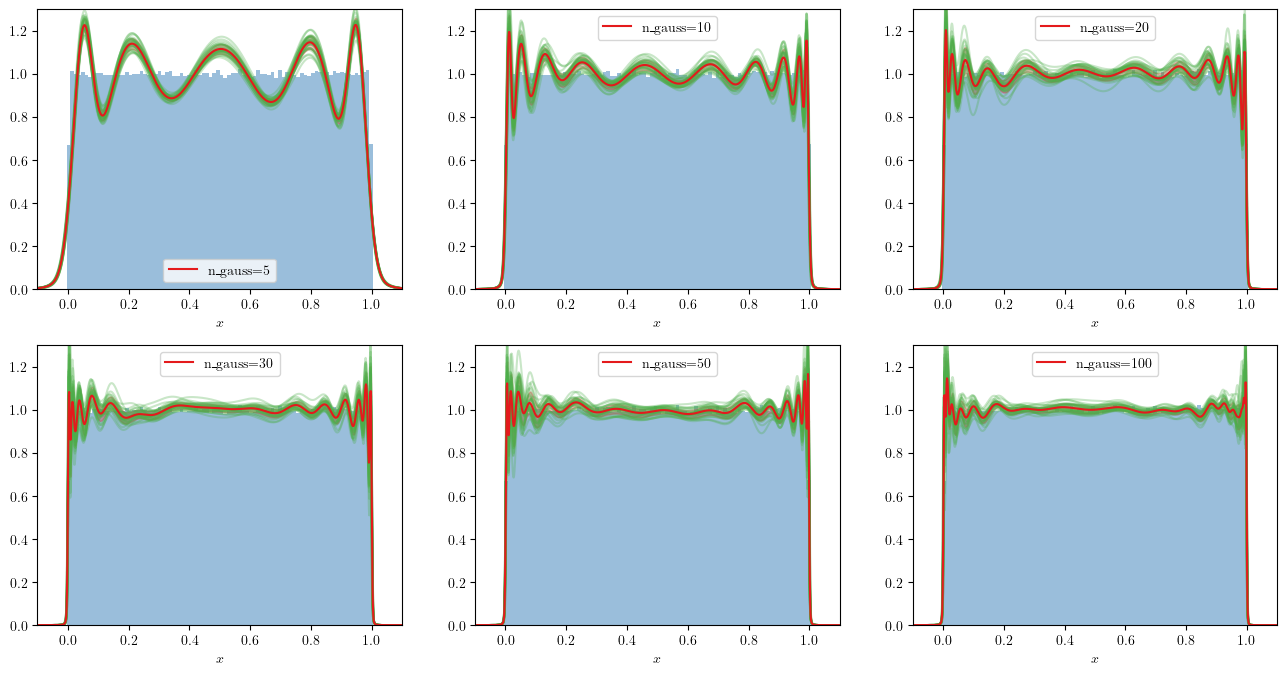

In [26]:
bins=100
xmin = -.1
xmax = 1.1
ymin = 0.
ymax = 1.3

fig=plt.figure(figsize=(16,8))

col = mpl.cm.Set1(np.linspace(0,1,9))
for i in range(len(ngauss)):
    
    fig.add_subplot(2,3,i+1)
    plt.hist(data[:,0], alpha=.5, bins=bins, range=(xmin, xmax), density=True, color=col[1], align="mid", rwidth=1.)

    igauss = ngauss[i]
    for j in range(nruns):
        plt.plot(xs, margL[:,i,j], color=col[2], alpha=.3)
    plt.plot(xs, meanMargL[:,i], color=col[0], alpha=1., label=f"n_gauss={igauss}")
    plt.fill_between(xs, meanMargL[:,i]+stdMargL[:,i], meanMargL[:,i]-stdMargL[:,i], color=col[0], alpha=.3)
    

    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.xlabel(r"$x$")
    plt.legend()
plt.savefig("Scripts/margUnc/balp3_flat.pdf", bbox_inches="tight")
plt.show()

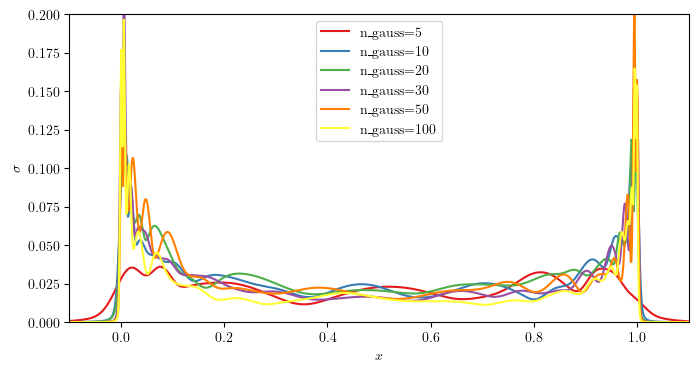

In [27]:
ymin = 0.
ymax = .2
fig=plt.figure(figsize=(8,4))
fig.add_subplot(1,1,1)
for i in range(len(ngauss)):
    igauss = ngauss[i]
    plt.plot(xs, stdMargL[:,i], color=col[i], label=f"n_gauss={igauss}")
    
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.xlabel(r"$x$")
    plt.ylabel(r"$\sigma$")
    plt.legend()
plt.savefig("Scripts/margUnc/balp3_flat_unc.pdf", bbox_inches="tight")
plt.show()

In [28]:
xs = np.zeros(prec)
margL = np.zeros((prec, len(ngauss), nruns))
for k in range(len(ngauss)):
    igauss = ngauss[k]
    runpath = f"runs/set15_gauss{igauss}_b3_BALP/"
    modelpath = runpath + "models/model_run0.pt"
    #modelpath = runpath + "models/model_epoch_1000.pt"
    parampath = runpath + "paramfile.yaml"
    params = load_params(parampath)
    params["device"]=get_device()
    model = AutoRegGMM(params)
    state_dict = torch.load(modelpath, map_location=params["device"])
    model.load_state_dict(state_dict)
    model.train_loader = DataLoader(dataset=data[:cut1], batch_size=params["batch_size"], shuffle=True)
    for j in range(nruns):
        if model.net.bayesian >= 1:
            model.net.map = get(model.params, "fix_mu", False)
            for i in range(model.net.n_blocks):
                model.net.transformer.h[i].mlp.c_fc.random = None
                model.net.transformer.h[i].mlp.c_proj.random = None
        if model.net.bayesian >= 2:
            for i in range(model.net.n_blocks):
                model.net.transformer.h[i].attn.c_attn.random = None
                model.net.transformer.h[i].attn.c_proj.random = None
        if model.net.bayesian >= 3:
            model.net.transformer.wte.random = None
            model.net.lm_head.random = None
        xs, margL[:,k,j] = getMargLikelihoodnDim(model, xmin, xmax, 1, prec=prec)

Model AutoRegGMM hyperparameters: n_head=4, n_per_head=15, n_blocks=4, intermediate_fac=4, n_gauss=5
Bayesianization hyperparameters: bayesian=3, prior_prec=1.0, iterations=20
Model AutoRegGMM hyperparameters: n_head=4, n_per_head=15, n_blocks=4, intermediate_fac=4, n_gauss=10
Bayesianization hyperparameters: bayesian=3, prior_prec=1.0, iterations=20
Model AutoRegGMM hyperparameters: n_head=4, n_per_head=15, n_blocks=4, intermediate_fac=4, n_gauss=20
Bayesianization hyperparameters: bayesian=3, prior_prec=1.0, iterations=20
Model AutoRegGMM hyperparameters: n_head=4, n_per_head=15, n_blocks=4, intermediate_fac=4, n_gauss=30
Bayesianization hyperparameters: bayesian=3, prior_prec=1.0, iterations=20
Model AutoRegGMM hyperparameters: n_head=4, n_per_head=15, n_blocks=4, intermediate_fac=4, n_gauss=50
Bayesianization hyperparameters: bayesian=3, prior_prec=1.0, iterations=20
Model AutoRegGMM hyperparameters: n_head=4, n_per_head=15, n_blocks=4, intermediate_fac=4, n_gauss=100
Bayesianizati

In [29]:
meanMargL = np.zeros((prec, len(ngauss)))
stdMargL = np.zeros((prec, len(ngauss)))
for i in range(len(ngauss)):
    meanMargL[:,i] = np.mean(margL[:,i,:], axis=1)
    stdMargL[:,i] = np.std(margL[:,i,:], axis=1)

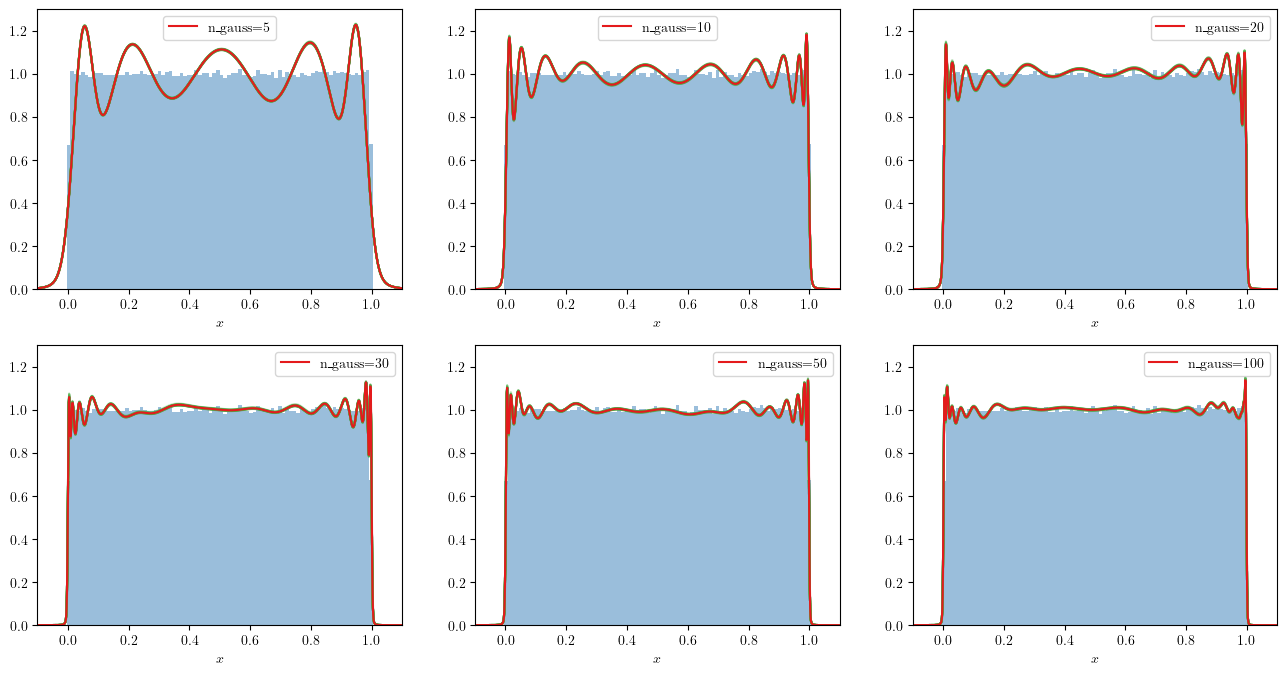

In [30]:
bins=100
xmin = -.1
xmax = 1.1
ymin = 0.
ymax = 1.3

fig=plt.figure(figsize=(16,8))

col = mpl.cm.Set1(np.linspace(0,1,9))
for i in range(len(ngauss)):
    
    fig.add_subplot(2,3,i+1)
    plt.hist(data[:,0], alpha=.5, bins=bins, range=(xmin, xmax), density=True, color=col[1], align="mid", rwidth=1.)

    igauss = ngauss[i]
    for j in range(nruns):
        plt.plot(xs, margL[:,i,j], color=col[2], alpha=.3)
    plt.plot(xs, meanMargL[:,i], color=col[0], alpha=1., label=f"n_gauss={igauss}")
    plt.fill_between(xs, meanMargL[:,i]+stdMargL[:,i], meanMargL[:,i]-stdMargL[:,i], color=col[0], alpha=.3)
    

    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.xlabel(r"$x$")
    plt.legend()
plt.savefig("Scripts/margUnc/balp3_flat2.pdf", bbox_inches="tight")
plt.show()

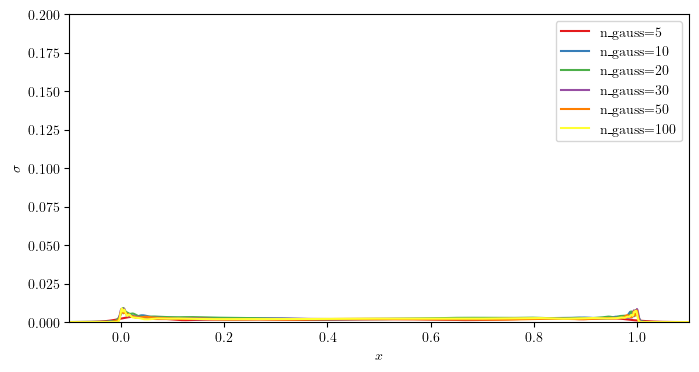

In [31]:
ymin = 0.
ymax = .2
fig=plt.figure(figsize=(8,4))
fig.add_subplot(1,1,1)
for i in range(len(ngauss)):
    igauss = ngauss[i]
    plt.plot(xs, stdMargL[:,i], color=col[i], label=f"n_gauss={igauss}")
    
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.xlabel(r"$x$")
    plt.ylabel(r"$\sigma$")
    plt.legend()
plt.savefig("Scripts/margUnc/balp3_flat2_unc.pdf", bbox_inches="tight")
plt.show()

# Uncertainties from BALPs (second dimension)

In [32]:
xs = np.zeros(prec)
margL = np.zeros((prec, len(ngauss), nruns))
for k in range(len(ngauss)):
    igauss = ngauss[k]
    runpath = f"runs/set15_gauss{igauss}_b3_BALP/"
    if igauss==50:
        runpath = f"runs/set15_gauss50_BALP_2/"
    modelpath = runpath + "models/model_run0.pt"
    #modelpath = runpath + "models/model_epoch_1.pt"
    parampath = runpath + "paramfile.yaml"
    params = load_params(parampath)
    params["device"]=get_device()
    model = AutoRegGMM(params)
    state_dict = torch.load(modelpath, map_location=params["device"])
    model.load_state_dict(state_dict)
    model.train_loader = DataLoader(dataset=data[:cut1], batch_size=params["batch_size"], shuffle=True)
    for j in range(nruns):
        if model.net.bayesian >= 1:
            model.net.map = get(model.params, "fix_mu", False)
            for i in range(model.net.n_blocks):
                model.net.transformer.h[i].mlp.c_fc.random = None
                model.net.transformer.h[i].mlp.c_proj.random = None
        if model.net.bayesian >= 2:
            for i in range(model.net.n_blocks):
                model.net.transformer.h[i].attn.c_attn.random = None
                model.net.transformer.h[i].attn.c_proj.random = None
        if model.net.bayesian >= 3:
            model.net.transformer.wte.random = None
            model.net.lm_head.random = None
        xs, margL[:,k,j] = getMargLikelihoodnDim(model, xmin, xmax, 0, prec=prec)

Model AutoRegGMM hyperparameters: n_head=4, n_per_head=15, n_blocks=4, intermediate_fac=4, n_gauss=5
Bayesianization hyperparameters: bayesian=3, prior_prec=1.0, iterations=20
Model AutoRegGMM hyperparameters: n_head=4, n_per_head=15, n_blocks=4, intermediate_fac=4, n_gauss=10
Bayesianization hyperparameters: bayesian=3, prior_prec=1.0, iterations=20
Model AutoRegGMM hyperparameters: n_head=4, n_per_head=15, n_blocks=4, intermediate_fac=4, n_gauss=20
Bayesianization hyperparameters: bayesian=3, prior_prec=1.0, iterations=20
Model AutoRegGMM hyperparameters: n_head=4, n_per_head=15, n_blocks=4, intermediate_fac=4, n_gauss=30
Bayesianization hyperparameters: bayesian=3, prior_prec=1.0, iterations=20
Model AutoRegGMM hyperparameters: n_head=4, n_per_head=15, n_blocks=4, intermediate_fac=4, n_gauss=50
Bayesianization hyperparameters: bayesian=2, prior_prec=1.0, iterations=20
Model AutoRegGMM hyperparameters: n_head=4, n_per_head=15, n_blocks=4, intermediate_fac=4, n_gauss=100
Bayesianizati

In [33]:
meanMargL = np.zeros((prec, len(ngauss)))
stdMargL = np.zeros((prec, len(ngauss)))
for i in range(len(ngauss)):
    meanMargL[:,i] = np.mean(margL[:,i,:], axis=1)
    stdMargL[:,i] = np.std(margL[:,i,:], axis=1)

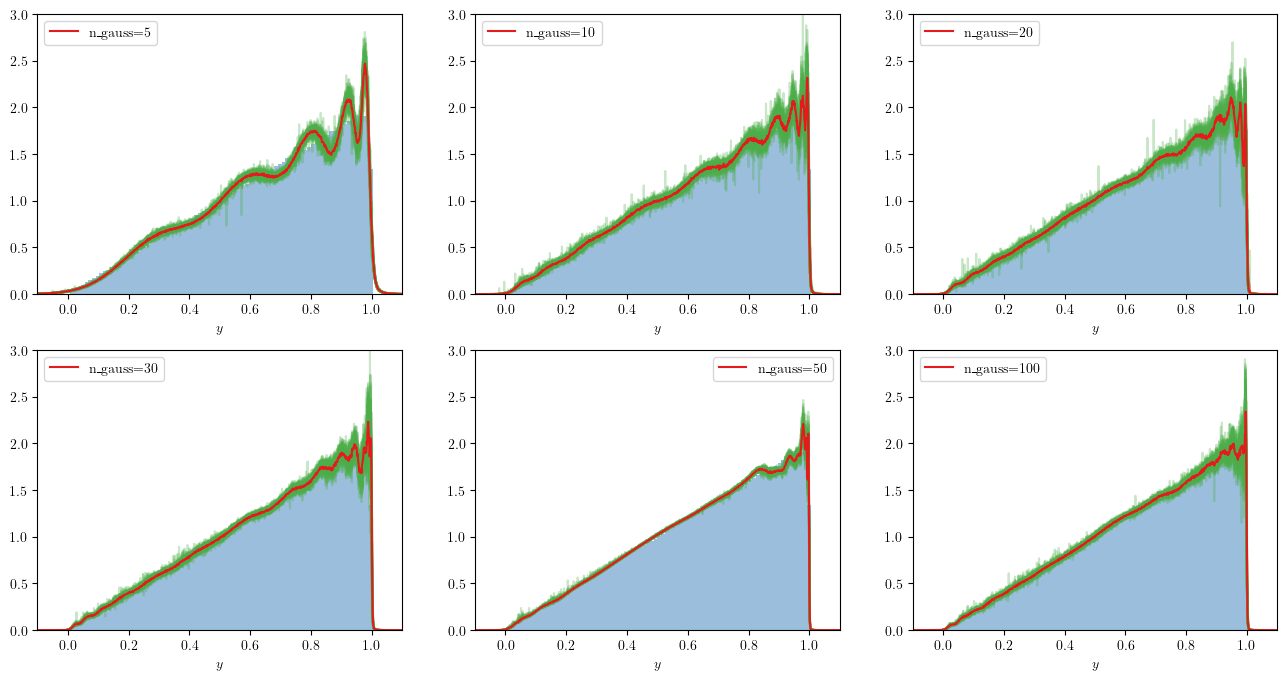

In [46]:
bins=100
xmin = -.1
xmax = 1.1
ymin = 0.
ymax = 3.

fig=plt.figure(figsize=(16,8))

col = mpl.cm.Set1(np.linspace(0,1,9))
for i in range(len(ngauss)):
    
    fig.add_subplot(2,3,i+1)
    plt.hist(data[:,1], alpha=.5, bins=bins, range=(xmin, xmax), density=True, color=col[1], align="mid", rwidth=1.)

    igauss = ngauss[i]
    for j in range(nruns):
        plt.plot(xs, margL[:,i,j], color=col[2], alpha=.3)
    plt.plot(xs, meanMargL[:,i], color=col[0], alpha=1., label=f"n_gauss={igauss}")
    plt.fill_between(xs, meanMargL[:,i]+stdMargL[:,i], meanMargL[:,i]-stdMargL[:,i], color=col[0], alpha=.3)
    

    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.xlabel(r"$y$")
    plt.legend()
plt.savefig("Scripts/margUnc/balp3_lin.pdf", bbox_inches="tight")
plt.show()

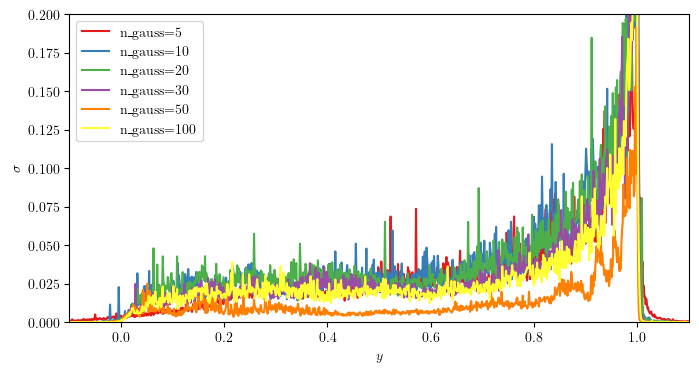

In [35]:
ymin = 0.
ymax = .2
fig=plt.figure(figsize=(8,4))
fig.add_subplot(1,1,1)
for i in range(len(ngauss)):
    igauss = ngauss[i]
    plt.plot(xs, stdMargL[:,i], color=col[i], label=f"n_gauss={igauss}")
    
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.xlabel(r"$y$")
    plt.ylabel(r"$\sigma$")
    plt.legend()
plt.savefig("Scripts/margUnc/balp3_lin_unc.pdf", bbox_inches="tight")
plt.show()